On transforme l'équation de Schrödinger
$i\hbar \frac{\partial\psi}{\partial t} = -\frac{\hbar^2}{2m} \Delta \psi + V\psi$ en $\frac{\partial\psi}{\partial t} = a \Delta \psi$ (sans potentiel) pour commencer. Pour adimensionner simplement et faire une première simulation, je prends $a=i=e^{i\pi/2}$.

### Création des matrices encodant du terme de droite et de gauche

In [4]:
using LinearAlgebra;

Créer la matrice pour la partie régressive de Crank-Nicholson (terme en indice de temps $n$)

In [5]:
function create_mat_reg(N,rx,ry) 
    J_reg =  rx*Matrix{ComplexF64}(I, N,N);

    mid_diag = (1-2*(rx+ry))*ones(ComplexF64,N); # définition vecteur de la diagonale
    extra_diag = ry*ones(ComplexF64,N-1);        # définition vecteur de la sur- et sous-diagonale

    H_reg = Tridiagonal(extra_diag, mid_diag, extra_diag);

    M_reg = Matrix{ComplexF32}(I,N*N,N*N);
    for i in 1:N
        @. M_reg[1+(i-1)*N:i*N,1+(i-1)*N:i*N] = H_reg[:,:]
    end

    for i in 1:N-1 # remplissages simultanés blocs extra diagonaux
        @. M_reg[1+(i-1)* N : i    *N, 1+(i)  *N :  (i+1)*N] = J_reg[:,:] # remplissage blocs supérieurs
        @. M_reg[1+(i)  * N : (i+1)*N, 1+(i-1)*N :      i*N] = J_reg[:,:] # remplissage blocs inférieurs
    end
    M_reg
end

# M_reg = create_mat_reg(55,1,2)

create_mat_reg (generic function with 1 method)

Créer la matrice pour la partie progressive de Crank-Nicholson (terme en indice de temps $n+1$)

In [6]:
function create_mat_pro(N,rx,ry)
    J_pro = -rx*Matrix{ComplexF64}(I, N,N);
    mid_diag = (1+2*(rx+ry))*ones(ComplexF64,N);
    outer_diag = -ry*ones(ComplexF64,N-1);

    H_pro = Tridiagonal(outer_diag, mid_diag, outer_diag);

    M_pro = Matrix{ComplexF32}(I,N*N,N*N);
    for i in 1:N
        @. M_pro[1+(i-1)*N:i*N,1+(i-1)*N:i*N] = H_pro[:,:]
    end

    for i in 1:N-1 # remplissages simultanés blocs extra diagonaux
        @. M_pro[1+(i-1)* N : i    *N,    1+(i)  *N :  (i+1)*N] = J_pro[:,:] # remplissage blocs supérieurs
        @. M_pro[1+(i)  * N : (i+1)*N,    1+(i-1)*N :      i*N] = J_pro[:,:] # remplissage blocs inférieurs
    end
    M_pro
end

# M_pro = create_mat_pro(55,1,2);

On calcule le conditionnement de la matrice $M_{pro}$

In [7]:
# print(cond(M_pro)) # apparemment on ne peut pas calculer un conditionnement sur une matrice de type Symmetric donc il faut le faire avant

Il faut que le conditionnement de $M_{pro}$ n'est pas trop petit ce qui ne pose pas de problème pour l'inverser. On calcule ensuite la matrice $M=M_{pro}^{-1}M_{reg}$ de telle sorte que l'on a $\psi^{(n+1)} = M \psi^{(n)}$

In [8]:
function create_mat_grad(N,rx,ry)
    M_pro = Symmetric(create_mat_pro(N,rx,ry))
    M_reg = Symmetric(create_mat_reg(N,rx,ry))
    M = inv(M_pro) * M_reg;
    print(typeof(M)); print("\n"),print(sizeof(M)/1024/1024);print("\n")
    M
end

# M = create_mat_grad(55,1,2);

### Création de l'état initial

In [35]:
function initial_state_matrix_ψ(L=7, N=100, σ=.4, kx=15*pi, ky=5*pi, x0=1, y0=2)
    δx = L/N;
    δy = L/N;
    ψ = Matrix{ComplexF32}(I,N,N);
    V(x,y) = exp(-1/2/σ^2*((x-x0)^2+(y-y0)^2) - im*kx*(x-x0) - im*ky*(y-y0));
    for i in 1:N
        for j in 1:N
            ψ[i,j] = V(i*δx ,j*δy);
        end
    end
    ψ
end

ψ0 = initial_state_matrix_ψ(7,100);

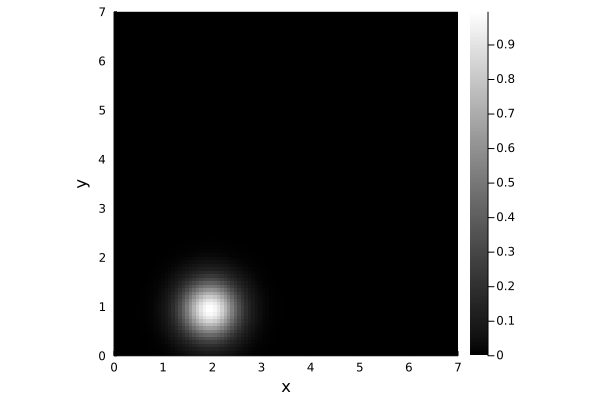

In [46]:
using Colors, Plots
heatmap(LinRange(0,7,100),LinRange(0,7,100),abs.(ψ0), xlabel="x", ylabel="y",xlims = (0,7), ylims=(0,7),color=:greys, aspect_ratio=:equal)

In [3]:
function propagate(ψ, M, t, Δt)
    n = ceil(Int, t/Δt)
    for i = 1:n
        ψ = M*ψ
    end
    ψ
end

function dynamics(T=.75, frames=300, tanim=9, Δt=5*1e-4, W=7, H=7, N=60, σ=.4, kx=5*pi, ky=5*pi, x0=5, y0=3)
    δx = W/N;
    δy = H/N;
    rx = -im*Δt/2/δx/δx;
    ry = -im*Δt/2/δy/δy;
    M = create_mat_grad(N,rx,ry);
    ψ = initial_state_matrix_ψ(N,δx,δy,σ,kx,ky,x0,y0);
    ψ = reshape(ψ,N*N);

    x = LinRange(0,W,N);
    y = LinRange(0,H,N);

    δt_frame = T/frames;
    anim = @animate for n = 1:frames
        # println("Frame $n/$frames")
        ψ = propagate(ψ, M, δt_frame, Δt); 
        ψ_plot = reshape(ψ,N,N);
        heatmap(w,y,abs.(ψ_plot), color=:greys, aspect_ratio=:equal)
    end
    fps = frames/tanim;
    gif(anim, fps=fps)
end;

LoadError: LoadError: UndefVarError: @animate not defined
in expression starting at c:\Users\matth\crank_nicholson.ipynb:22

Matrix{ComplexF32}
98.876953125


┌ Info: Saved animation to 
│   fn = C:\Users\matth\AppData\Local\Temp\jl_EYQ4bJLuCo.gif
└ @ Plots C:\Users\matth\.julia\packages\Plots\tXtrW\src\animation.jl:114


Plots.AnimatedGif("C:\\Users\\matth\\AppData\\Local\\Temp\\jl_EYQ4bJLuCo.gif")
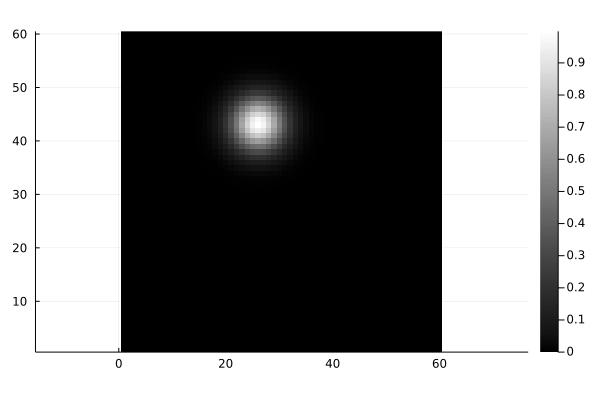

In [31]:
dynamics()